In [1]:
import xml.etree.cElementTree as et
import pandas as pd
import numpy as np
import requests

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

from scipy.stats import norm

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.debugger import set_trace

# Step 1: Acquire Data From CSV File

In [2]:
beach_complete = pd.read_csv('beach_complete.csv',delimiter=',',header=0,index_col=0)

In [3]:
beach_clean = beach_complete.dropna()

In [4]:
beach_clean.apply(pd.to_numeric);

In [28]:
beach_clean['average'] = beach_clean.mean(1)

/home/rkumar/anaconda3/envs/DS1ENV/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
beach_clean.head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9,average
sampleDate,,,,,,,,,,,,
2009-06-01,27.0,12.0,39.0,28.0,11.0,18.0,24.0,63.0,51.0,10.0,10.0,26.636364
2009-06-02,10.0,14.0,52.0,16.0,10.0,18.0,22.0,18.0,19.0,10.0,10.0,18.090909
2009-06-03,22.0,11.0,14.0,10.0,10.0,11.0,14.0,10.0,10.0,10.0,10.0,12.000000
2009-06-04,26.0,10.0,11.0,10.0,10.0,11.0,11.0,10.0,10.0,10.0,10.0,11.727273
2009-06-05,35.0,10.0,31.0,11.0,10.0,10.0,10.0,12.0,10.0,10.0,10.0,14.454545
2009-06-06,133.0,13.0,29.0,18.0,12.0,10.0,12.0,16.0,10.0,12.0,10.0,25.000000
2009-06-07,604.0,16.0,20.0,97.0,37.0,28.0,41.0,47.0,10.0,12.0,11.0,83.909091
2009-06-08,405.0,17.0,99.0,142.0,31.0,33.0,43.0,39.0,10.0,10.0,12.0,76.454545
2009-06-10,170.0,25.0,155.0,26.0,11.0,18.0,21.0,11.0,12.0,18.0,31.0,45.272727


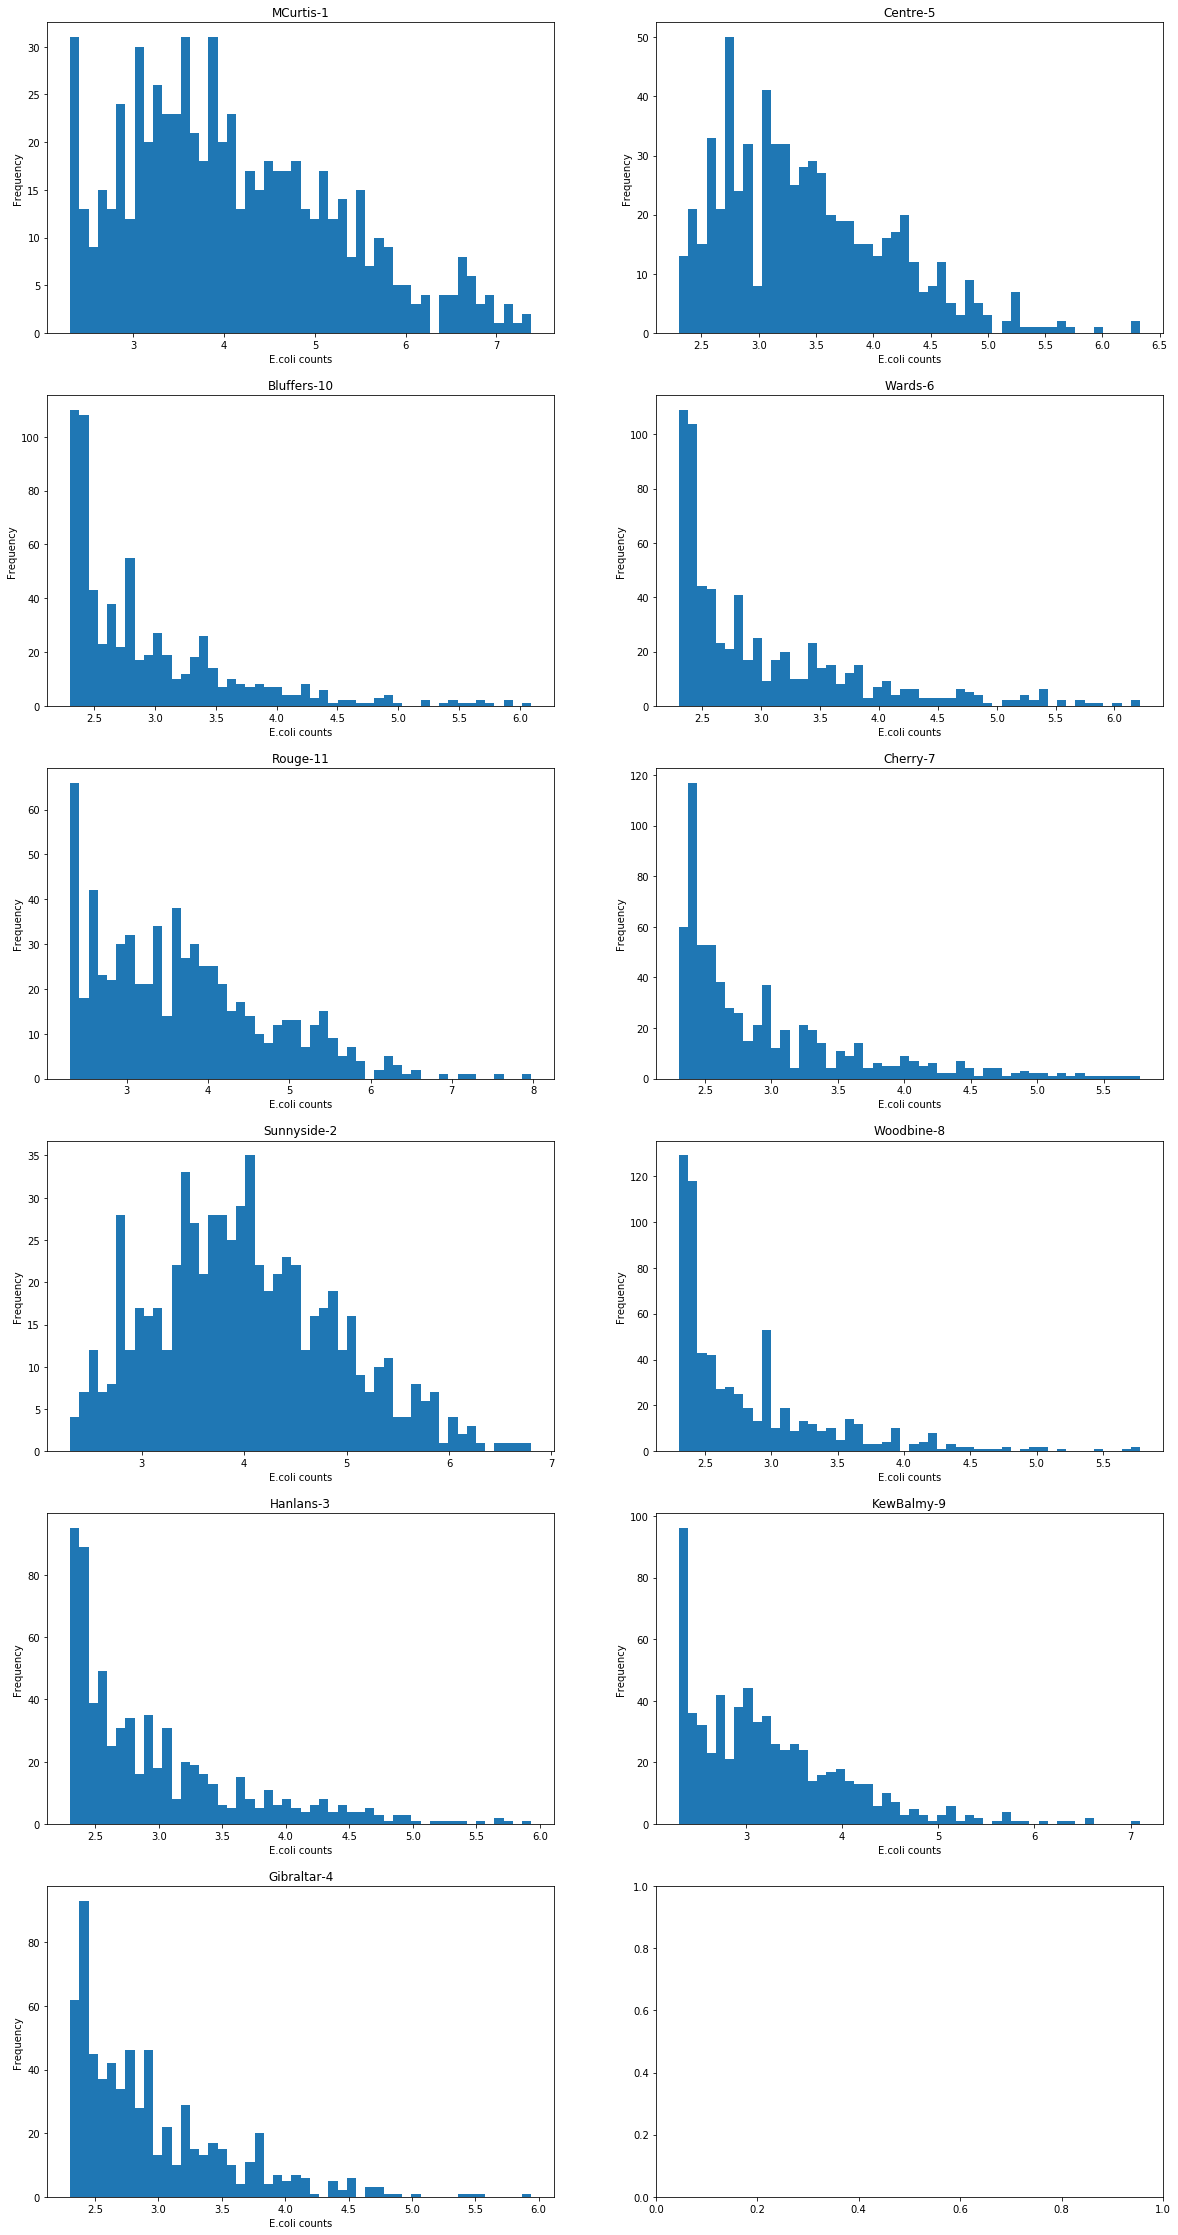

In [30]:
fig, ax = plt.subplots(6, 2, figsize=(20,40))
cols = beach_clean.columns
for i in range(6):
    for j in range(2):
        if j == 1 and i == 5:
            break
        elif j == 0:
            ax[i][j].hist(np.log(beach_clean[cols[i]].values), bins=50, histtype='stepfilled')
            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i])
           #set_trace()
        else:
            ax[i][j].hist(np.log(beach_clean[cols[i+6]]).values, bins=50, histtype='stepfilled')
            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i+6])

In [7]:
sunnyside = beach_clean[['Sunnyside-2']]

In [8]:
mcurtis = beach_clean[['MCurtis-1']]

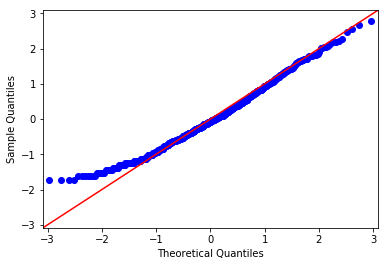

In [9]:
qqplot(np.log(sunnyside['Sunnyside-2']/750)+2.6,line='45');

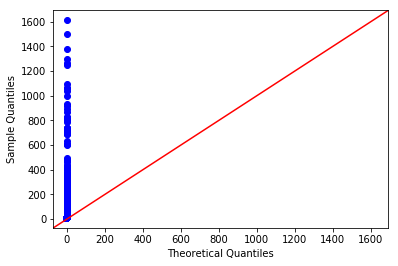

In [10]:
qqplot(mcurtis['MCurtis-1'],line='45');

In [11]:
sunnyside.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 2009-06-01 to 2018-09-03
Data columns (total 1 columns):
Sunnyside-2    668 non-null float64
dtypes: float64(1)
memory usage: 10.4+ KB


In [12]:
sunnyside.head()

,Sunnyside-2
sampleDate,
2009-06-01,28.0
2009-06-02,16.0
2009-06-03,10.0
2009-06-04,10.0
2009-06-05,11.0


In [13]:
sunnyside = sunnyside.reset_index()

In [14]:
sunnyside.head()

,sampleDate,Sunnyside-2
0,2009-06-01,28.0
1,2009-06-02,16.0
2,2009-06-03,10.0
3,2009-06-04,10.0
4,2009-06-05,11.0


In [15]:
# plt.hist(sunnyside.values, bins=30, histtype='bar', color='green', label = 'Sunnyside')
# plt.legend()
# plt.show();

In [16]:
# sunnyside.plot(color='red', label = 'Sunnyside')
# plt.legend()
# plt.show();

# Step 2: ACF and PACF plots

In [17]:
# fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,4))
# plot_acf(sunnyside, lags=50, title='Sunnyside ACF', ax=ax[0])
# plot_pacf(sunnyside, lags=50, title='Sunnyside PACF', ax=ax[1])
# plt.show();

# Step 5: Setup Train and Test

In [18]:
train_size = int(0.7 * sunnyside['Sunnyside-2'].size)
test_size = int(0.3 * sunnyside['Sunnyside-2'].size)

In [19]:
train_size, test_size

(467, 200)

In [20]:
sunnyside['Label'] = 0
for i in sunnyside.index:
    if i >= train_size:
        sunnyside.loc[i, 'Label'] = 1

In [21]:
sunnyside.head(), sunnyside.tail()

(   sampleDate  Sunnyside-2  Label
 0  2009-06-01         28.0      0
 1  2009-06-02         16.0      0
 2  2009-06-03         10.0      0
 3  2009-06-04         10.0      0
 4  2009-06-05         11.0      0,      sampleDate  Sunnyside-2  Label
 663  2018-08-24         97.0      1
 664  2018-08-28        423.0      1
 665  2018-08-29        308.0      1
 666  2018-08-30        158.0      1
 667  2018-09-03        132.0      1)

# Step 6: ARIMA Model

In [22]:
sunnyside['Predictions'] = 0
sunnyside['Errors'] = 0

In [23]:
sunnyside['Sunnyside-2'][sunnyside['Label'] == 0].values

array([ 28.,  16.,  10.,  10.,  11.,  18.,  97., 142.,  26.,  12.,  14.,
        20.,  19.,  14.,  16.,  37.,  65., 149.,  49.,  80., 119.,  88.,
       182., 172.,  30.,  17., 201., 228.,  83.,  42.,  32., 115., 258.,
        83.,  49., 222., 815., 276.,  60.,  30.,  61.,  28.,  75.,  93.,
        86.,  65., 127., 123.,  68.,  65.,  61.,  35.,  88., 102.,  30.,
        44.,  55.,  29.,  37., 117., 233., 107., 104.,  53., 131., 467.,
       111.,  40.,  69., 100.,  61.,  55., 186., 371., 336., 142., 122.,
        75.,  39., 128., 125.,  64.,  88.,  61.,  87.,  67., 200., 513.,
       309., 144.,  60., 129., 194., 244., 129.,  37.,  53.,  56.,  69.,
        90.,  56.,  49.,  52.,  93., 225., 125.,  38.,  43.,  44.,  94.,
       122.,  29.,  76., 106., 117.,  54., 108., 126.,  70.,  63.,  55.,
        41.,  27.,  53., 140.,  48.,  35.,  66.,  42.,  18.,  27.,  29.,
        16.,  16.,  22.,  69.,  80.,  22.,  57., 284., 542., 447.,  33.,
        63.,  26.,  11.,  18.,  43.,  32.,  15.,  3

In [24]:
for i in sunnyside.index:
    if sunnyside.loc[i, 'Label'] == 1:
        model = ARIMA(endog=sunnyside['Sunnyside-2'][sunnyside['Label'] == 0].values, order=(5,1,1)).fit()
        sunnyside.loc[i, 'Predictions'] = model.forecast()[0][0]
        sunnyside.loc[i, 'Errors'] = model.forecast()[1][0]
        sunnyside.loc[i, 'Label'] = 0

In [25]:
sunnyside['sampleDate'] = pd.to_datetime(sunnyside['sampleDate'])
years = sunnyside['sampleDate'].dt.year
years = years.drop_duplicates()
years

0      2009
48     2010
125    2011
201    2012
263    2013
330    2014
392    2015
465    2016
537    2017
593    2018
Name: sampleDate, dtype: int64

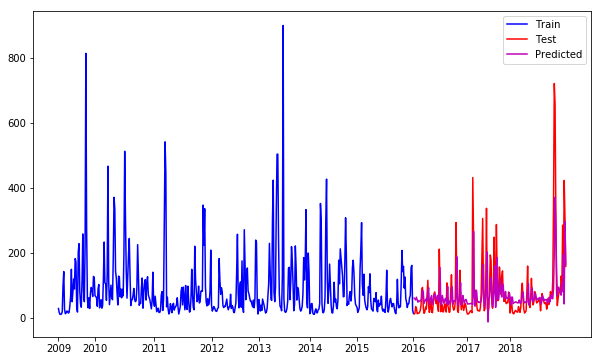

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(sunnyside.index[:train_size], sunnyside['Sunnyside-2'][:train_size], 'b-', label='Train')
ax.plot(sunnyside.index[train_size:train_size+test_size], 
        sunnyside['Sunnyside-2'][train_size:train_size+test_size], 'r-', label='Test')
ax.plot(sunnyside.index[train_size:train_size+test_size], 
        sunnyside['Predictions'][train_size:train_size+test_size], 'm-', label='Predicted')
plt.xticks(years.index, years)
plt.legend()
plt.show();

In [27]:
rmse = np.sqrt(mean_squared_error(sunnyside['Sunnyside-2'][train_size:train_size+test_size],
                                  sunnyside['Predictions'][train_size:train_size+test_size]))
rmse

79.22660541587126